In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from google.colab import drive
import os
import pickle
from scipy.signal import find_peaks, argrelextrema
from scipy.spatial.distance import cdist

In [2]:
def RK4step(func, current_state, t, dt):
    k1 = func(t, current_state)
    k2 = func(t + 0.5 * dt, current_state + 0.5 * dt * k1)
    k3 = func(t + 0.5 * dt, current_state + 0.5 * dt * k2)
    k4 = func(t + dt, current_state + dt * k3)
    return current_state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

In [3]:
class LorenzSystem:

    def __init__(self):
        self.sigma = 10.0
        self.rho = 28.0
        self.beta = 8.0 / 3.0
        self.state = np.array([1, 1, 1])

    def __call__(self, t, u):
        return np.array([
            self.sigma * (u[1] - u[0]),
            u[0] * (self.rho - u[2]) - u[1],
            u[0] * u[1] - self.beta * u[2]
        ])

    def reinitialise_ic(self):
        self.state = np.array([1, 1, 1])

    def randomise_ic(self):
        self.state = 2 * (np.random.rand(self.state.size) - 0.5)

In [4]:
class ReservoirComputer:
    def __init__(self, drive_system, reservoir_size, connectivity, spectral_radius, gamma, sigma):
        self.rng_M = np.random.default_rng(1911)
        self.rng_Win = np.random.default_rng(1912)
        self.rng_state = np.random.default_rng(1913)

        self.r = 2 * (self.rng_state.random(reservoir_size) - 0.5)
        self.u = drive_system
        self.spectral_radius = spectral_radius
        self.connectivity = connectivity
        self.reservoir_size = reservoir_size

        self.M, self.original_M, self.sparsification_mask = self.generate_matrix_and_mask(reservoir_size, connectivity, spectral_radius)
        self.Win = self.generate_Win(reservoir_size, self.u.state.size)

        self.sigma = sigma
        self.gamma = gamma
        self.res_update_func_listen = self.reservoir_update_equation
        self.res_update_func_pred = self.reservoir_update_equation_prediction

        self.dt = 0.01
        self.t = 0.0
        self.beta = 0.001
        self.q = lambda x: np.concatenate((np.array(x), np.array(x)**2))
        self.A = None
        self.b = None
        self.phi = None

    def generate_matrix_and_mask(self, reservoir_size, connectivity, spectral_radius):
        M = 2 * (self.rng_M.random((reservoir_size, reservoir_size)) - 0.5)
        sparsification_mask = self.rng_M.binomial(1, connectivity, size=(reservoir_size, reservoir_size))
        original_M = M.copy()
        sparsification_mask_copy = sparsification_mask.copy()
        M *= sparsification_mask
        M *= spectral_radius / max(np.abs(np.linalg.eigvals(M))).real
        return M, original_M, sparsification_mask_copy

    def generate_Win(self, reservoir_size, input_size):
        Win = np.zeros((reservoir_size, input_size))
        random_cols = self.rng_Win.integers(0, input_size, reservoir_size)
        random_values = self.rng_Win.uniform(-1, 1, reservoir_size)
        Win[np.arange(reservoir_size), random_cols] = random_values
        return Win

    def reservoir_update_equation(self, t, r):
        return self.gamma * (-r + np.tanh(self.M @ r + self.sigma * self.Win @ self.u.state))

    def reservoir_update_equation_prediction(self, t, r):
        return self.gamma * (-r + np.tanh(self.M @ r + self.sigma * self.Win @ self.phi(self.q(r))))

    def listen(self, t_listen):
        num_timesteps = int(t_listen / self.dt)

        for _ in range(num_timesteps):
            self.u.state = RK4step(self.u, self.u.state, self.t, self.dt)
            self.r = RK4step(self.res_update_func_listen, self.r, self.t, self.dt)
            self.t += self.dt

    def train(self, t_train):
        num_timesteps = int(t_train / self.dt)

        u_states = []
        symmetry_broken_r_states = []
        for _ in range(num_timesteps):
            self.u.state = RK4step(self.u, self.u.state, self.t, self.dt)
            u_states.append(self.u.state)
            self.r = RK4step(self.res_update_func_listen, self.r, self.t, self.dt)
            symmetry_broken_r_states.append(self.q(self.r))
            self.t += self.dt

        u_states = np.array(u_states)
        symmetry_broken_r_states = np.array(symmetry_broken_r_states)
        self.parameterise_phi(symmetry_broken_r_states, u_states)

    def predict(self, t_predict):
        num_timesteps = int(t_predict / self.dt)

        predictions = [self.phi(self.q(self.r))]
        for _ in range(num_timesteps):
            self.r = RK4step(self.res_update_func_pred, self.r, self.t, self.dt)
            prediction = self.phi(self.q(self.r))
            predictions.append(prediction)
            self.t += self.dt

        return np.array(predictions)

    def parameterise_phi(self, X, Y):
        n = X.shape[0]
        dims_x = X.shape[1]
        dims_y = Y.shape[1]
        A = np.linalg.inv(X.T @ X + self.beta * np.identity(dims_x)) @ X.T @ Y
        b = (1 / n) * np.sum(Y - X @ A, axis=0)
        self.A = A
        self.b = b
        self.phi = lambda x: self.A.T @ x + self.b
        #self.phi = lambda x: x @ self.A + self.b

    def set_spectral_radius(self, spectral_radius):
        if spectral_radius == 0:
            self.M = np.zeros_like(self.original_M)
        else:
            self.M = (self.original_M * self.sparsification_mask) * (spectral_radius / max(np.abs(np.linalg.eigvals(self.original_M * self.sparsification_mask))).real)
        self.spectral_radius = spectral_radius

    def time_ts(self, natural_time):
        return int(natural_time/self.dt)

    def reinitialise_same_RC(self):
        self.reinitialise_state()
        self.u.reinitialise_ic()
        self.A = None
        self.b = None
        self.phi = None

    def reinitialise_state(self):
        self.r = 2 * (self.rng_state.random(self.reservoir_size) - 0.5)
        self.t = 0.0

    def reinitialise_M(self):
        self.M, self.original_M, self.sparsification_mask = self.generate_matrix_and_mask(self.reservoir_size, self.connectivity, self.spectral_radius)

    def reinitialise_Win(self):
        self.Win = self.generate_Win(self.reservoir_size, self.u.state.size)

    def reinitialise_RC(self):
        self.reinitialise_M()
        self.reinitialise_Win()
        self.reinitialise_state()

In [5]:
def time_ts(natural_time):
        return int(natural_time/0.01)

In [6]:
class ReservoirComputer_BulkSimulation(ReservoirComputer):
    def __init__(self, drive_system, reservoir_size, connectivity, spectral_radius, gamma, sigma):
        super().__init__(drive_system, reservoir_size, connectivity, spectral_radius, gamma, sigma)

    def predict_100(self, t_predict):
        predictions_100 = []
        for _ in range(100):
            self.reinitialise_state()
            predictions = self.predict(t_predict)
            predictions_100.append(predictions)

        print("Predictions complete")
        return np.array(predictions_100)

    def simulate_100(self, t_listen, t_train, t_predict):
        self.rng_state = np.random.default_rng(1913)
        self.reinitialise_same_RC()

        self.listen(t_listen)
        self.train(t_train)
        trajectories = self.predict_100(t_predict)
        return np.array(trajectories)

In [7]:
lorenz = LorenzSystem()                 # U(t)
reservoir_size = 100                    # N
connectivity = 0.05                     # P
spectral_radius = 0.6                   # ρ
gamma = 10.0                            # γ
sigma = 0.2                             # σ

In [8]:
params = (lorenz, reservoir_size, connectivity, spectral_radius, gamma, sigma)

In [9]:
times = (100, 100, 100)

In [10]:
def generate_spectral_radii_list(start, end, steps):
  spectral_radii = np.linspace(start, end, steps)
  spectral_radii = [np.round(p, 4) for p in spectral_radii]
  spectral_radii = [str(p) for p in spectral_radii]
  return spectral_radii

#From Here down is regenerating the network topology used in the reservoir confuguration of interest.

It was observed that for the 4th network topology there was
- One limit cycle at 0.0
- Lorenz and 2 Limit cycles at 0.05
- The same one limit cycle at 0.1.

Hence 0.025, 0.026, ......, 0.075 are tested to see.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

def save_dictionary(dictionary, file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(file_path, 'wb') as file:
        pickle.dump(dictionary, file, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'Dictionary saved to {file_path}')

def load_dictionary(file_path):
    with open(file_path, 'rb') as file:
        loaded_dictionary = pickle.load(file)
    print(f"Data loaded successfully from {file_path}")
    return loaded_dictionary

Mounted at /content/drive


In [12]:
spectral_radii_from_generation_notebook = np.linspace(0, 0.8, 17)

In [13]:
file_path = f'drive/My Drive/bifurcation_analysis_data/{spectral_radii_from_generation_notebook[1]}_M.pkl'
file_path

'drive/My Drive/bifurcation_analysis_data/0.05_M.pkl'

In [14]:
_, seed = load_dictionary(file_path)
seed = seed[3]

Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.05_M.pkl


In [15]:
def RC_regen_from_seed(params, seed, randomised_parameter):
  RC_B = ReservoirComputer_BulkSimulation(*params)
  if randomised_parameter == "M":
    RC_B.rng_M.bit_generator.state = seed
    RC_B.reinitialise_M()
  else:
    RC_B.rng_Win.bit_generator.state = seed
    RC_B.reinitialise_Win()
  return RC_B

# Here follows the test for bifurcation images.

In [16]:
spectral_radii_Lorenz_birth = generate_spectral_radii_list(0.0, 0.01, 11)
spectral_radii_Lorenz_death = generate_spectral_radii_list(0.060, 0.0632, 32)

spectral_radii_Lorenz_death

['0.06',
 '0.0601',
 '0.0602',
 '0.0603',
 '0.0604',
 '0.0605',
 '0.0606',
 '0.0607',
 '0.0608',
 '0.0609',
 '0.061',
 '0.0611',
 '0.0612',
 '0.0613',
 '0.0614',
 '0.0615',
 '0.0617',
 '0.0618',
 '0.0619',
 '0.062',
 '0.0621',
 '0.0622',
 '0.0623',
 '0.0624',
 '0.0625',
 '0.0626',
 '0.0627',
 '0.0628',
 '0.0629',
 '0.063',
 '0.0631',
 '0.0632']

In [17]:
RC_B = RC_regen_from_seed(params, seed, "M")
trajectories_list = []
for p in spectral_radii_Lorenz_birth:

  RC_B.set_spectral_radius(float(p))

  # take the precalculated value of the current seed from its placeholder and calculate the seed state for the next matrix generation again
  trajectories = RC_B.simulate_100(*times)
  trajectories_list.append(trajectories)

  print(f"\033[1mSimulation complete for ρ = {p} \033[0m")

results = np.array(trajectories_list)
trajectories_bulk = results

Predictions complete
Simulation complete for ρ = 0.0 
Predictions complete
Simulation complete for ρ = 0.001 
Predictions complete
Simulation complete for ρ = 0.002 
Predictions complete
Simulation complete for ρ = 0.003 
Predictions complete
Simulation complete for ρ = 0.004 
Predictions complete
Simulation complete for ρ = 0.005 
Predictions complete
Simulation complete for ρ = 0.006 
Predictions complete
Simulation complete for ρ = 0.007 
Predictions complete
Simulation complete for ρ = 0.008 
Predictions complete
Simulation complete for ρ = 0.009 
Predictions complete
Simulation complete for ρ = 0.01 


In [98]:
trajectories_bulk.shape

(2, 100, 10001, 3)

# Display these simulations

In [20]:
def display_bifurcation_simulation(ax, trajectories, title):
    for i in range(100):
        t = trajectories[i]
        x1 = t[time_ts(70):, 0]
        x3 = t[time_ts(70):, 2]
        ax.plot(x1, x3)
        # ax.set_xlim(-60, 50)
        # ax.set_ylim(-150, 250)
    #ax.set_title(title)
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_3$')

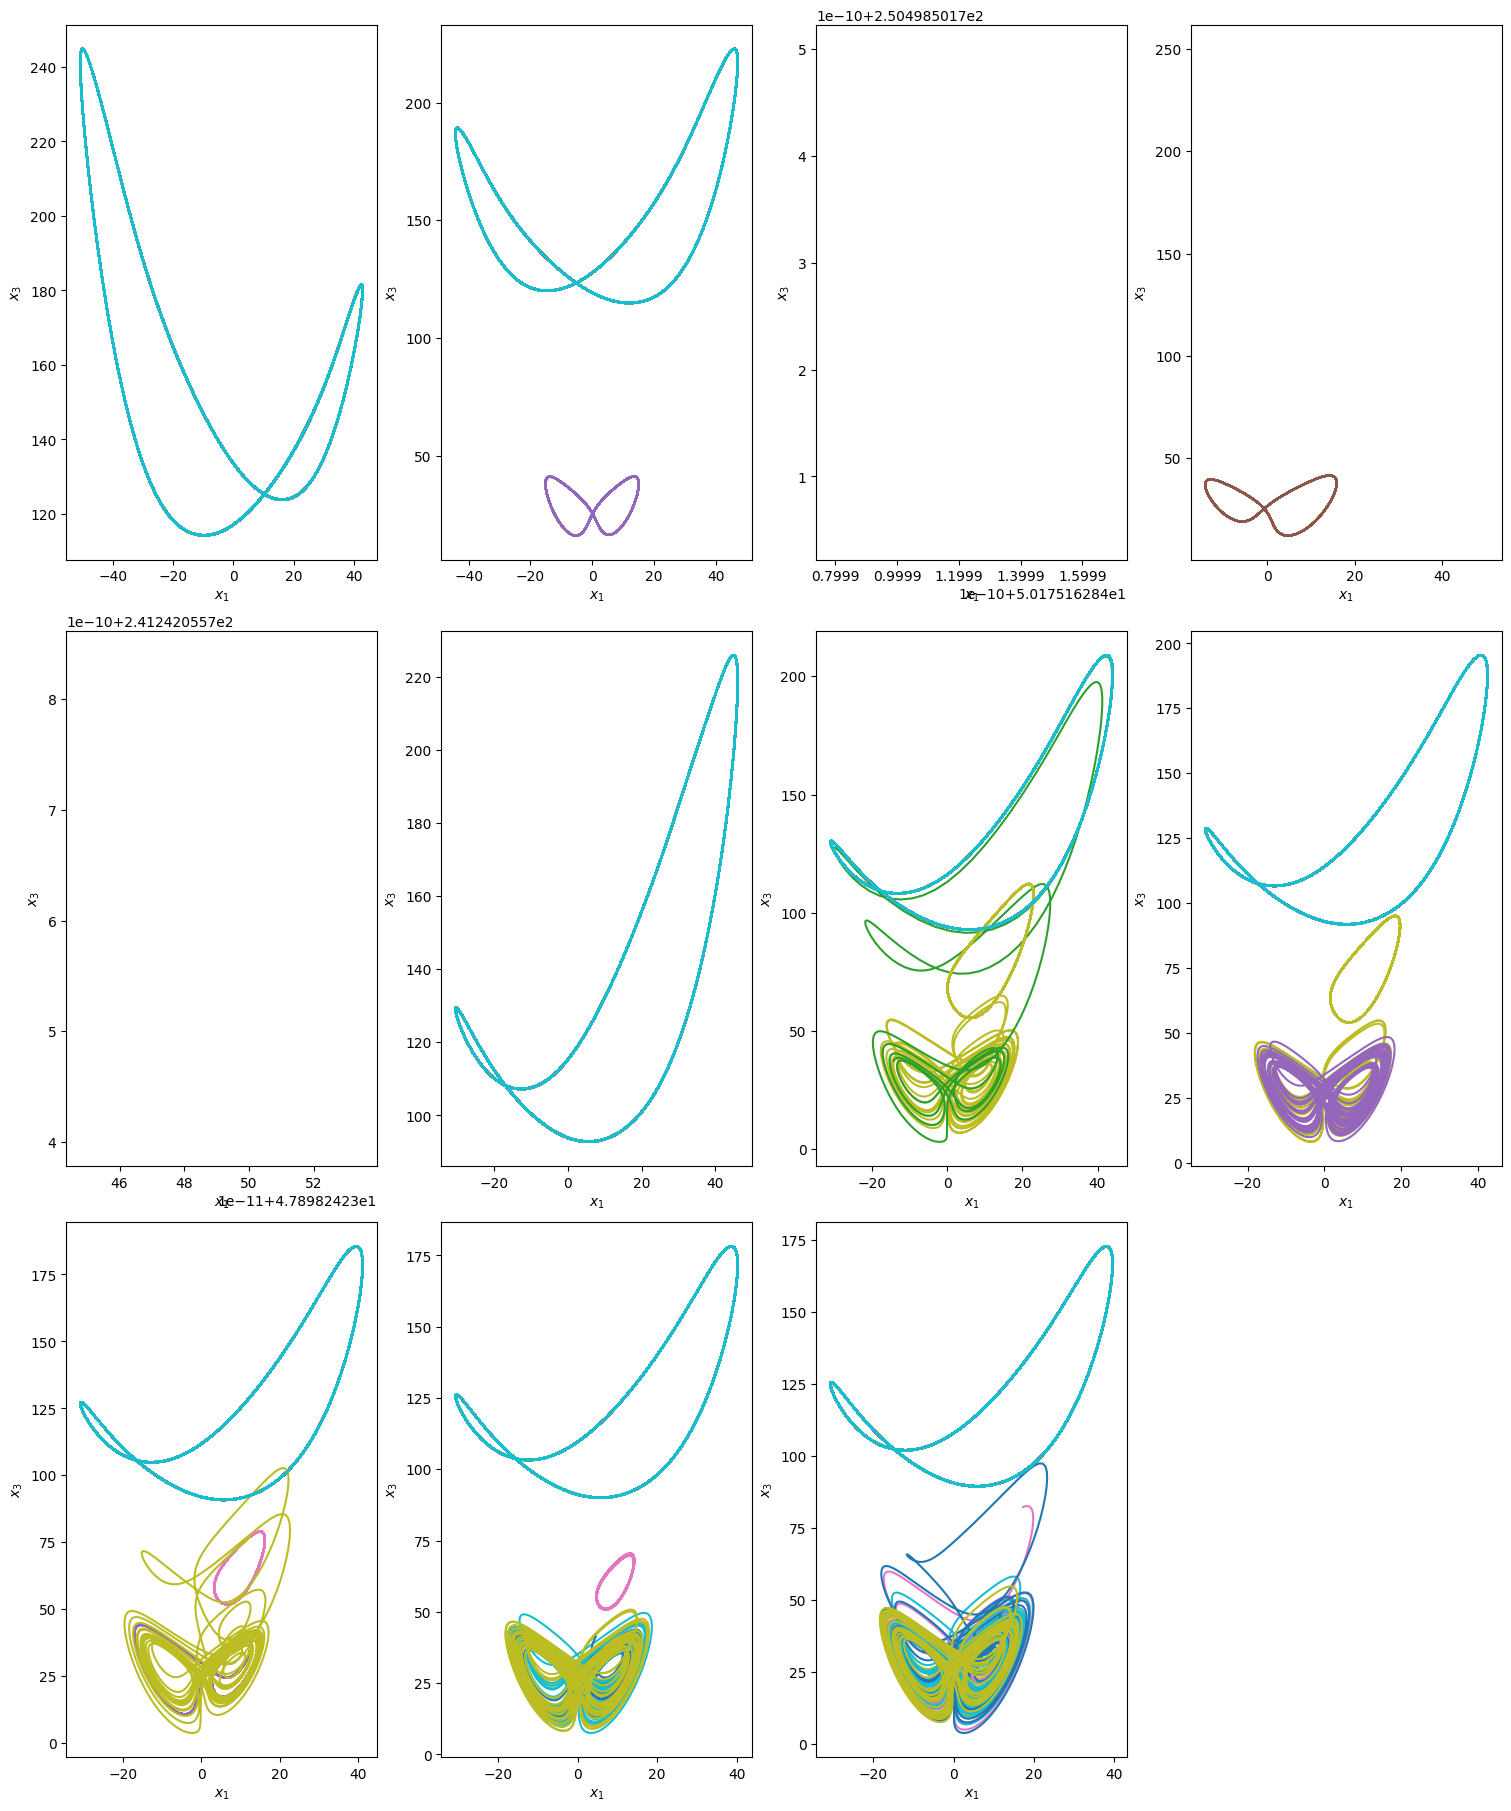

In [21]:
num_plots = trajectories_bulk.shape[0]
num_cols = 4
num_rows = int(np.ceil(num_plots / num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6 * num_rows), constrained_layout=True)
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i < num_plots:
        trajectories = trajectories_bulk[i]
        display_bifurcation_simulation(ax, trajectories, f'{np.round(float(p), 4)}')
    else:
        ax.axis('off')

plt.show()

In [18]:
file_path1 = f'drive/My Drive/RC_thesis_misc_data/birth_Lorenz_M_index_3.pkl'
file_path2 = f'drive/My Drive/RC_thesis_misc_data/death_Lorenz_M_index_3.pkl'

In [19]:
save_dictionary(file_path2, np.array(trajectories_bulk))

TypeError: expected str, bytes or os.PathLike object, not ndarray